<a href="https://colab.research.google.com/github/lauraliron/APRENDIZAJE_AUTOMATICO_23_24/blob/main/AA_ProyectoFinal_Grupo_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.ufv.es/wp-content/uploads/2023/03/logo-UFV-scaled.jpg" alt="Logo de Colab" width="200">

# <font color='00008B'>GRUPO 6.</font>
##### Laura Lirón Carrión, Alberto Muñoz Gutierrez, Nuria Prol Vecoña.

# <font color='00008B'>PROYECTO FINAL.</font>

# **Introducción:**


En la oftalmología, detectar enfermedades oculares rápido es esencial para tratarlas a tiempo. Antes, los doctores examinaban los ojos directamente lo qu epodía llegar a ser subjetivo, pero ahora, con la inteligencia artificial (IA), se pueden usar imágenes del ojo para encontrar problemas más rápido.

Un proyecto anterior, EyeCNN, usó IA para reconocer tres enfermedades oculares con una precisión del 94%. Este trabajo nos dice la eficacia de las redes neuronales convolucionales en el diagnóstico por computadora de enfermedades oculares, demostrando su capacidad para aprender características detalladas de las enfermedades oculares y proporcionar diagnósticos precisos.

Inspirados en ese éxito, nuestro proyecto quiere hacer algo similar, pero con una base de datos más grande que incluye seis enfermedades diferentes, al igual que retinas sanas.

Al expandir el número de condiciones que nuestro modelo puede detectar, esperamos proporcionar una herramienta valiosa para los oftalmólogos, aumentando la precisión del diagnóstico y acelerando el proceso para que los pacientes puedan recibir tratamiento lo antes posible


# **Datos:**

Los datos que se van a utilizar para el estudio del diagnostico de enfermedades de los ojos la obtuvimos a partir de una base de datos de kaggle. Es por eso que comenzamos instalando la api de kaggle que nos sirve para descargar y subir conjuntos de datos.


In [1]:
!pip install kaggle

In [2]:
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
import random
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lauraliron","key":"f4198c816bd4403c051646ef006d5e48"}'}

In [4]:
!mkdir ~/.kaggle
!mv kaggle.json /root/.kaggle/

Este comando utiliza la API de Kaggle para descargar el conjunto de datos especificado (andrewmvd/ocular-disease-recognition-odir5k) donde estan contenidos los datos.

In [5]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

100% 1.62G/1.62G [01:24<00:00, 21.2MB/s]
100% 1.62G/1.62G [01:24<00:00, 20.7MB/s]


Usamos **!ls** para mirar los archivos y directorios en el directorio que descargamos y como salida vemmos que el conjunto de datos se encuentra en un archivo zip y además un directorio con datos de prueba.

In [6]:
!ls

ocular-disease-recognition-odir5k.zip  sample_data


Se descomprime el archivo ZIP `ocular-disease-recognition-odir5k.zip`

In [7]:
# Función para descomprimir archivos
def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Rutas de los archivos ZIP y carpetas de destino
zip_paths = ['/content/ocular-disease-recognition-odir5k.zip']
extract_paths = ['/content/ocular-disease-recognition-odir5k']

for zip_path, extract_path in zip(zip_paths, extract_paths):
    unzip_file(zip_path, extract_path)


Una vez que el archivo esta descomprimido estudiamos que es lo que contiene.
Se obtiene un archivo csv, una carpeta llamada ODIR-5k y un conjunto de imágenes que han sido preprocesadas de alguna manera (por ejemplo, redimensionadas, normalizadas, etc.)

In [8]:
!ls /content/ocular-disease-recognition-odir5k

full_df.csv  ODIR-5K  preprocessed_images


Los datos encontrados en la carpeta ODIR-5k (Ocular Disease Recognition) son:
- Un archivo excel con los datos de las imágenes
- Una carpeta con imágenes para entrenar el modelo
- Una carpeta con imágenes para probar y evaluar la eficacia y precisión del modelo

In [9]:
!ls /content/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K

 data.xlsx  'Testing Images'  'Training Images'


Abrimos entonces el archivo Excel y lo mostramos en pantalla para ver que tipo de datos se van a manejar a largo del proyecto.
En el archivo, cada paciente tiene una fila dedicada con varios detalles: su número de ID, edad, sexo, una foto de su ojo izquierdo y otra del derecho, palabras clave para el diagnóstico de cada ojo y, finalmente, una lista de enfermedades con una marca de '1' si el paciente las tiene y '0' si no.

Estas enfermedades son las siguientes:

* N = Normal
* D = Diabetes
* G = Glaucoma
* C = Catarata
* A = Degeneración macular relacionada con la edad
* H = Hipertensión
* M = Miopía patológica
* O = Otras enfermedades

In [10]:
file_path = "/content/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx"
data = pd.read_excel(file_path)

# opción de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

df = pd.DataFrame(data)
print(df.head())

   ID  Patient Age Patient Sex Left-Fundus Right-Fundus                           Left-Diagnostic Keywords               Right-Diagnostic Keywords  N  D  G  C  A  H  M  O
0   0           69      Female  0_left.jpg  0_right.jpg                                           cataract                           normal fundus  0  0  0  1  0  0  0  0
1   1           57        Male  1_left.jpg  1_right.jpg                                      normal fundus                           normal fundus  1  0  0  0  0  0  0  0
2   2           42        Male  2_left.jpg  2_right.jpg  laser spot，moderate non proliferative retinopathy  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1
3   3           66        Male  3_left.jpg  3_right.jpg                                      normal fundus         branch retinal artery occlusion  0  0  0  0  0  0  0  1
4   4           53        Male  4_left.jpg  4_right.jpg                        macular epiretinal membrane       mild nonproliferative retinopath

Vemos ahora que contiene la carpeta de testing images, guardamos en la variable test_dir la ruta del directorio donde se almacenan las imágenes de prueba.

Se imprime la variable para ver de que forma se encuentran los datos, vienen en formato jpg, como imágenes, por lo que procedemos a imprimirlas. Estos archivos muestran en el nombre si se trata de un ojo derecho o izquierdo.  

Para tener una primera impresión de los datos con los que trabajaremos, hemos decidido visualizar las primeras cinco imágenes del conjunto de prueba. Esto nos dará una idea clara del tipo de imágenes que estamos manejando y nos ayudará a planificar los próximos pasos en nuestro análisis. Estas primeras cinco imágenes nos permitirán ver la consistencia en el formato y la calidad de las imágenes.


Archivos en el directorio de prueba: ['4224_left.jpg', '3333_left.jpg', '2427_right.jpg', '2403_left.jpg', '3268_left.jpg', '3103_left.jpg', '4265_right.jpg', '3982_left.jpg', '4142_left.jpg', '2838_left.jpg', '4523_left.jpg', '3191_right.jpg', '638_left.jpg', '2875_right.jpg', '1165_left.jpg', '3221_right.jpg', '4348_left.jpg', '2176_right.jpg', '2561_right.jpg', '31_left.jpg', '1594_left.jpg', '2555_left.jpg', '3123_right.jpg', '3115_left.jpg', '2873_left.jpg', '2797_right.jpg', '4312_right.jpg', '982_right.jpg', '2980_left.jpg', '4647_left.jpg', '652_right.jpg', '3272_right.jpg', '858_left.jpg', '675_right.jpg', '300_right.jpg', '4040_right.jpg', '3319_left.jpg', '2479_left.jpg', '585_right.jpg', '571_left.jpg', '3348_left.jpg', '4655_right.jpg', '2625_left.jpg', '393_right.jpg', '744_left.jpg', '4375_right.jpg', '1431_right.jpg', '189_left.jpg', '3119_right.jpg', '4105_right.jpg', '1862_left.jpg', '2841_left.jpg', '4270_left.jpg', '67_right.jpg', '3384_right.jpg', '1371_right.jpg',

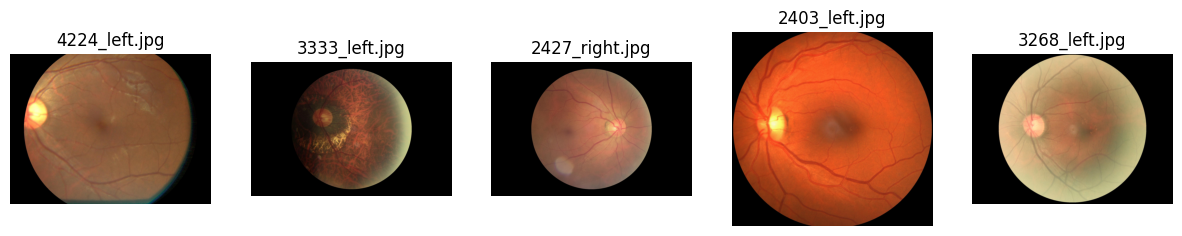

In [11]:
test_dir = '/content/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images'
print("Archivos en el directorio de prueba:", os.listdir(test_dir))

cinco = os.listdir(test_dir)[:5]

plt.figure(figsize=(15, 10))

for i, image_name in enumerate(cinco, 1):
    image_path = os.path.join(test_dir, image_name)
    img = Image.open(image_path)

    # Un subplot para cada imagen
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_name)

plt.show()

Se crean ahora dos funciones para cargar las imagenes y las asociarlas con su etiqueta correspondiente

**Función etiqueta:**

Esta función se encarga de extraer las etiquetas de cada imagen basándose en una fila de datos (información de un paciente).
Recibe una fila y revisa una lista de posibles etiquetas (como 'N' para normal, 'D' para diabetes, etc.).
Si en la fila se marca una enfermedad con un '1', la etiqueta correspondiente se agrega a una lista.
Si no encuentra ninguna etiqueta marcada con '1', devuelve ['Unknown']. De esta forma en la variable labels, se guardaran las enfermedades que contiene cada ojo.


**Función cargar_imagenes:**

Está diseñada para cargar imágenes desde un directorio dado y asociarlas con sus etiquetas.
Primero comprueba si el archivo existe.
Si existe, busca en un DataFrame (que contiene datos de pacientes) la fila que corresponde a esa imagen, ya sea el ojo izquierdo o derecho.

Luego, carga la imagen, la convierte en un array y la normaliza (cambia el rango de los valores de píxeles de 0-255 a 0-1).

Usa la función etiqueta para obtener las etiquetas de esa imagen y las guarda.
Finalmente, devuelve dos cosas: un array de todas las imágenes y una lista de todas las etiquetas (que pueden ser múltiples etiquetas por imagen).


In [12]:
def etiqueta(fila):
    # Columnas que representan las etiquetas
    label_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    labels = []
    for label in label_columns:
        if fila[label] == 1:
            labels.append(label)
    return labels if labels else ['Unknown']

def cargar_imagenes(directory, df):
    images = []
    multi_labels = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        if os.path.exists(img_path):
            # Buscar la fila correspondiente en el DataFrame
            fila = df[(df['Left-Fundus'] == filename) | (df['Right-Fundus'] == filename)]
            if not fila.empty:
                img = image.load_img(img_path, target_size=(150, 150))
                img_array = image.img_to_array(img) / 255.0
                images.append(img_array)

                labels = etiqueta(fila.iloc[0])  # Obtener la primera fila si hay varias coincidencias
                multi_labels.append(labels)
            else:
                print(f"Archivo {filename} no encontrado.")
    return np.array(images), multi_labels

Utilizamos las funciones previamente creadas para obetener los datos de entrenamiento y de test.

Despues se preparan las etiquetas, se usa **MultiLabelBinarizer** ya que estamos en un caso donde las imágenes pueden tener multietiquetas. MultiLabelBinarizer transforma las etiquetas en un formato binario donde cada etiqueta tiene su propia columna y la presencia de la clase se marca con un 1, y su ausencia con un 0.

Por ultimo se imprime el numero de imagenes que hemos cargado y al hacerlo vemos que ninguna imagen de test fue cargada correctamente ya que el nombre del archivo no se encuentra en ninguna fila del Excel, por lo que para esas imágenes solo tenemos la foto pero no tenemos información de lo que representan. No las utilizaremos ya que no tendríamos como comprobar si nuestro modelo se comporta de manera exitosa o no.

In [13]:
train_dir = '/content/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images'
train_images, train_labels = cargar_imagenes(train_dir, df)

test_dir = '/content/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Testing Images'
test_images, test_labels = cargar_imagenes(test_dir, df)


# Preprocesamiento de etiquetas
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_labels)
test_labels = mlb.transform(test_labels)

print(f"Número de imágenes de entrenamiento: {len(train_images)}")
print(f"Número de imágenes de prueba: {len(test_images)}")

Archivo 4744_left.jpg no encontrado.
Archivo 1502_left.jpg no encontrado.
Archivo 3477_right.jpg no encontrado.
Archivo 1737_left.jpg no encontrado.
Archivo 3510_left.jpg no encontrado.
Archivo 1449_left.jpg no encontrado.
Archivo 1128_right.jpg no encontrado.
Archivo 1916_left.jpg no encontrado.
Archivo 1201_left.jpg no encontrado.
Archivo 4711_right.jpg no encontrado.
Archivo 4721_right.jpg no encontrado.
Archivo 3561_right.jpg no encontrado.
Archivo 2263_left.jpg no encontrado.
Archivo 1882_right.jpg no encontrado.
Archivo 1363_left.jpg no encontrado.
Archivo 3455_left.jpg no encontrado.
Archivo 4747_left.jpg no encontrado.
Archivo 3508_right.jpg no encontrado.
Archivo 1128_left.jpg no encontrado.
Archivo 3524_left.jpg no encontrado.
Archivo 4735_left.jpg no encontrado.
Archivo 1179_right.jpg no encontrado.
Archivo 4691_right.jpg no encontrado.
Archivo 1684_left.jpg no encontrado.
Archivo 4716_left.jpg no encontrado.
Archivo 3556_left.jpg no encontrado.
Archivo 1078_left.jpg no enco

Como solo vamos a usar los datos de entrenamiento para este modelo volvemos a cargar las imágenes y las etiquetas.

Para mantener la aleatoriedad se combinan las imágenes y las etiquetas en una lista de tuplas para mantener la correspondencia entre cada imagen y su etiqueta. Luego, mezclamos esta lista para asegurar una distribución aleatoria de los datos.

Después del mezclado, separa nuevamente las imágenes y las etiquetas.
Y a partir de este conjunto mezclado tomamos una parte para datos de entrenamiento y otra parte de test para la evaluación.

Preparamos las etiquetas con MultiLabelBinarizer e imprimos los tamaños de los nuevos conjuntos.

Contamos ahora con 5600 imagenes para entrenar y 1400 imagenes que el modelo no verá hasta la etapa de evaluación.

In [14]:
del train_images
import gc
gc.collect()

images, labels = cargar_imagenes(train_dir, df)

# Shuffle de los datos manteniendo el vínculo entre imágenes y etiquetas
combined = list(zip(images, labels))
random.shuffle(combined)
images[:], labels[:] = zip(*combined)

# División en conjuntos de entrenamiento y prueba
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42)

# Preprocesamiento de etiquetas
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_labels)
test_labels = mlb.transform(test_labels)


print(f"Número de imágenes de entrenamiento: {len(train_images)}")
print(f"Número de imágenes de prueba: {len(test_images)}")



Número de imágenes de entrenamiento: 5600
Número de imágenes de prueba: 1400



Para determinar si la base de datos es adecuada para resolver este problema mediante redes neuronales convolucionales, es crucial examinar si cada enfermedad está representada por una cantidad suficiente de imágenes, asegurando así la representatividad y efectividad del modelo.

Conteo de imágenes por etiqueta:
{'N': 2280, 'A': 328, 'D': 2256, 'M': 348, 'C': 424, 'H': 206, 'O': 1958, 'G': 430}


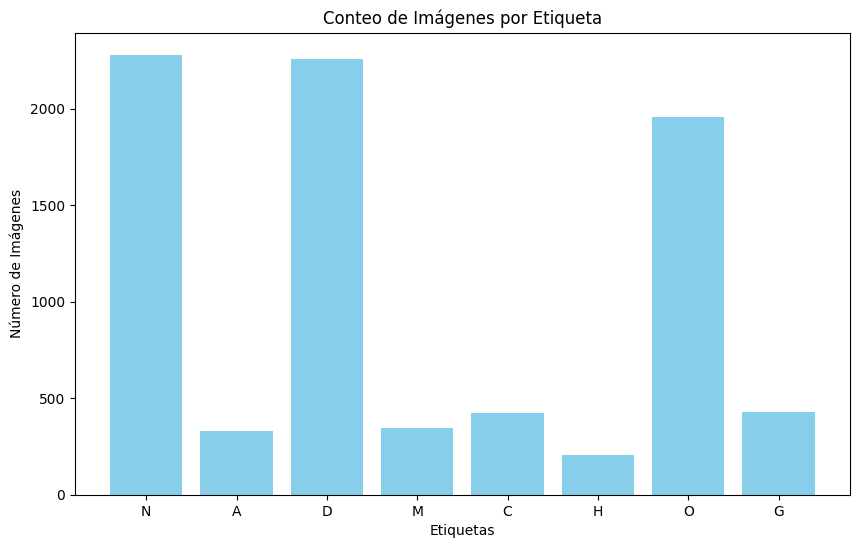

In [15]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from collections import Counter

# Aplanar la lista de etiquetas y contarlas
etiquetas_planas = [etiqueta for sublist in labels for etiqueta in sublist]
conteo_etiquetas = dict(Counter(etiquetas_planas))

print("Conteo de imágenes por etiqueta:")
print(conteo_etiquetas)

# Gráfico de barras para visualizar el conteo de etiquetas
etiquetas = list(conteo_etiquetas.keys())
conteos = list(conteo_etiquetas.values())

plt.figure(figsize=(10, 6))
plt.bar(etiquetas, conteos, color='skyblue')
plt.xlabel('Etiquetas')
plt.ylabel('Número de Imágenes')
plt.title('Conteo de Imágenes por Etiqueta')
plt.show()

Hay una notable desigualdad en la cantidad de imágenes disponibles para cada etiqueta. Por ejemplo, las etiquetas 'N' y 'O' tienen más de 1900 imágenes cada una, mientras que 'H' tiene solo 206. Esta desigualdad puede llevar a un sesgo en el modelo, donde las enfermedades con más datos (como 'N' y 'O') se predicen con mayor precisión que aquellas con menos datos (como 'H' y 'C').



# **Métodos:**

Se resolverá el problema utilizando redes convolucionales.

A diferencia de otros métodos de aprendizaje automático, las redes convolucionales tienen una habilidad única para procesar y analizar imágenes, manteniendo y aprovechando la estructura espacial de los datos. Utilizan filtros para identificar y resaltar características importantes en las imágenes, lo cual es crucial en la detección de patrones específicos asociados con distintas condiciones oculares.

Además, las operaciones de pooling en las redes convolucionales ayudan a reducir la complejidad computacional sin perder las características esenciales. Otro gran beneficio es su capacidad para el transfer learning, permitiendo utilizar modelos preentrenados y adaptarlos a conjuntos de datos específicos. Esta especialización en el procesamiento de imágenes hace a las redes convolucionales una herramienta más adecuada para tareas de visión por computadora en comparación con algoritmos de aprendizaje automático más genéricos. A continuación se explica más detalladamente como funcionan este tipo de redes.

 Hemos construido el modelo de forma secuencial, lo que facilita la comprensión y el ensamblaje de las capas de la red, cada una con una entrada y salida bien definidas.

El proceso de aprendizaje se organiza en capas, en cuanto a las capas convolucionales, las primeras se centran en aprender características simples, mientras que las capas posteriores se especializan en características más complejas. Cada capa convolucional emplea filtros, también llamados kernels, que se aplican a la imagen. Cada filtro está diseñado para reconocer una característica específica.

Comenzamos empleando capas convolucionales `Conv2D` con funcion de activación `relu`. La elección de ReLU se debe a su eficiencia y a su capacidad para evitar el problema del gradiente desvaneciente en redes profundas y permitiendo así la identificación de patrones más complejos.

En el interior de cada capa convolucional, se selecciona el número de filtros, y cada uno aprende características distintas. Estos filtros operan simultáneamente en la imagen, generando un mapa de características al desplazarse por la imagen con una ventana deslizante. Cada neurona en el mapa de características se conecta a una región de la imagen, y cada filtro tiene su propio mapa asociado. Esta capa deslizante se desliza según el stride* indicado, si no se especifica nada tomará el valor de 1.

En contraste con las capas densas, las capas convolucionales se especializan en la detección de patrones locales en lugar de patrones globales, lo que las convierte en una elección adecuada para la identificación de características visuales en imágenes. Además, estas capas aprenden jerarquías espaciales para comprender la importancia de la posición de una característica dentro de la imagen, como la ubicación de los ojos en un rostro.


Posteriormente, las capas de agrupación `MaxPooling2D` reducen las dimensiones espaciales del mapa de características, lo que disminuye el riesgo de sobreajuste y reduce la cantidad de cálculos requeridos, manteniendo las características más importantes. La capa de pooling garantiza la invarianza a la traslación y se centra en resaltar lo más relevante de la información visual. Max pooling es computacionalmente menos caro que average pooling y además obtiene mejores resultados.


La normalización por lotes `BatchNormalization` se aplica después de cada capa de pooling para estabilizar y acelerar el proceso de aprendizaje, asegurando que las entradas a cada capa tengan una distribución más uniforme.

Aplanamos con una capa `Flatten` y para evitar el sobreajuste, integramos una capa de `Dropout` antes de la capa final. Esto ayuda a que el modelo generalice mejor, "desactivando" aleatoriamente algunas neuronas durante el entrenamiento.

En la última capa, utilizamos 8 neuronas con la función de activación `sigmoid`. A diferencia de una activación `softmax`, que se usa en clasificaciones multiclase donde cada imagen se clasifica en una sola categoría, la función **`sigmoid`** permite una clasificación independiente para cada clase, tratándolas como 8 problemas de clasificación binaria diferentes. Esto es adecuado para situaciones en las que cada ejemplo podría pertenecer a varias clases simultáneamente.

La función sigmoide devuelve únicamente valores entre 0 y 1; cuanto más grande sea la entrada más se acerca el valor que devuele la función a 1, en el caso de que la entrada sea cero, la salida será 0.5 y cuanto más negativa sea la entrada, la salida se acercará más a cero. Puede que hayan casos en donde la función ocasione desvanecimiento de gradiente cuando la entrada es muy grande en valor absoluto. Otro problema es al no ser una función centrada en cero puede lentizar la convergencia en algunos casos.

Es importante señalar que durante el proceso de entrenamiento, los filtros en cada capa convolucional ajustan sus valores de manera aleatoria para minimizar el error, lo que da lugar a un comportamiento emergente sin necesidad de instrucciones explícitas sobre qué buscar.

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(1024, activation='relu',  kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(8, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 74, 74, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                        

**Explicación Summary:**

`Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))`

Se agrega una capa convolucional (Conv2D) al modelo con 32 filtros, cada uno tendrá una ventana deslizante de tamaño 3 * 3. La función de activación utilizada es ReLU ('relu'). Además, se especifica la forma de entrada (input_shape) que es (150, 150, 3), lo que significa que la entrada se espera que sea una imagen de 150x150 píxeles con 3 canales de color (RGB).

El output shape de esta capa es (None, 148, 148, 32): El None se refiere a que toma un conjunto de datos con un lote o batch de dimension variable. Después son las medidas del mapa de características que devolverá cada uno de los 32 filtros, que será de 148 * 148. El tamaño del mapa se calcula de la siguiente forma: 150 (Tamaño entrada) - 3 (tamaño ventana deslizante) + 1 (stride).

Esta capa tiene 896 parámetros editables: 3 * 3 (Dimensión de la ventana de la capa) * 3 (canales de entrada) * 32 (filtros) + 32 (sesgo), se le añade un parametro bias por cada filtro aplicado.

`model.add(MaxPooling2D((2, 2))`

Se añade una capa de pooling (MaxPooling2D) después de la capa convolucional. Esta capa realiza un submuestreo seleccionando el valor máximo de una región (2x2) en el mapa de características resultante. Esto ayuda a reducir la dimensionalidad y a capturar las características más relevantes.

Output shape:(None, 74, 74, 32): Los 32 filtros de la capa convolucional se reducen a la mitad, miden ahora 74 * 74. Este cambio se logra al elegir solo uno de cada cuatro valores en la región que abarca la ventana, utilizando un stride de 1 (bajando fila por fila). En consecuencia, el mapa de características se reduce a la mitad en términos de su resolución espacial.

Las capas de pooling no editan ningún parámetro ya que solo reducen el tamaño del mapa de características condensando la imágen, pero sin realizar cambios en los pesos.

`BatchNormalization()`

Output shape: (None, 74, 74, 32): indica que después de la operación de normalización por lotes, la salida sigue teniendo la misma altura y anchura espacial de 74x74 píxeles y 32 filtros.

`model.add(Conv2D(64, (3, 3), activation='relu'))`

`model.add(MaxPooling2D((2, 2))`

Se añade otra capa de convolucion y otra de pooling para estudiar características más profundas de las imágenes, esta capa le aplicara 64 filtros a cada uno de los 32 mapas de características de la capa pasada.

Output shape de la capa convolucional es (None, 72, 72, 64): 64 mapas de características de tamaño 72 * 72. El tamaño del mapa se calcula de la siguiente forma: 74 (Tamaño mapa anterior) - 3 (tamaño ventana deslizante) + 1 (stride).

Esta capa ajusta un total de 18,496  parámetros, calculados mediante la fórmula (3 * 3 * 32 + 1) * 64 = 18,496. Esto se desglosa en un tamaño de ventana de 3x3, con 32 filtros provenientes de la capa anterior, y se añade 1 para representar el sesgo de cada uno de los 64 nuevos filtros. La multiplicación por 64 se refiere al número de filtros en la capa actual, conectando cada filtro nuevo con los 32 filtros anteriores.

El output shape de la segunda capa de pooling son los 64 mapas reducidos a la mitad de tamaño, (None, 36, 36, 64). Vuelve a usar el mismo criterio de la primera capa de pooling, quedarse unicamente con el mayor de los 4 de la región que abarca la ventana deslizante. Con 0 parametros editables ya que solo reduce dimensión de mapas.

Así se obtienen las salidas de todas las demás capas siguientes de convolución y pooling.

`model.add(Flatten())`

Se añade una capa de aplanamiento (Flatten) que convierte el mapa de características tridimensional resultante en un vector unidimensional. Esto es necesario antes de conectarlo a capas densas. Su output shape es (None, 73984) obtenido tras multiplicar los valores de la capa anterior, 17 * 17 * 256

`Dense(1024, activation='relu',  kernel_regularizer='l2')`

Output shape: (None, 1024), 1024 neuronas en esta capa que son las que le estamos indicando que debe tener.

Parámetros:  75,760,640 los parámetros se calculan multiplicando el número de entradas (73,984) por el número de neuronas en la capa (1024), y luego sumando 1024 sesgos (uno para cada neurona).

`Dropout(0.5)`

Output shape: (None, 1024), 1024 neuronas de la capa densa anterior

`Dense(8, activation='sigmoid')`

Output shape: (None, 8), 8 neuronas en esta capa que son las que le estamos indicando que debe tener, ya que son el número de clases a las que la imagen puede pertenecer.

Parámetros: 8,200; estos parámetros vienen de multiplicar las 1024 entradas por las 8 neuronas de salida, y sumando 8 sesgos.

---

Se compila ahora la red de neuronas, dentro del compilador se especifica que optimizador se utilizará. El optimizador se utilizará para ajustar los pesos de la red durante el proceso de entrenamiento. El optimizador es un algoritmo que se encarga de minimizar la función de pérdida (loss function) al ajustar los pesos. Se utiliza Rmsprop, una variante del SGD pero este optimizador ajusta la tasa de aprendizaje de cada parámetro.
El optimizador `rmsprop` es una elección sólida para este modelo, ya que es efectivo en la gestión de los gradientes y ayuda en la convergencia rápida del modelo durante el entrenamiento.

Después se asigna la funcion de pérdida que se utilizará para calcular la diferencia entre las predicciones del modelo y las etiquetas reales.En este caso, se utiliza 'binary_crossentropy'. Al calcular la pérdida o la precisión, la red obtiene una medida cuantitativa de su rendimiento en los datos de entrenamiento.

Por último, se especifica la métrica o métricas que se deben evaluar y mostrar durante el entrenamiento y la evaluación del modelo, en este caso sea por precisión.

La pérdida `binary_crossentropy` se utiliza aquí para cada clase individual, y la precisión se calcula de manera independiente para cada una de las 8 clases


In [17]:
# Compilación del modelo
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])



**Separación de Conjuntos de Entrenamiento y Validación:**

Se establece el tamaño del conjunto de validación (validation_size) en 1,000 imágenes. Este número de asegurar que el conjunto de validación sea lo suficientemente grande como para ser representativo de la distribución general de datos.

train_images_val y train_label_val contienen las primeras 1,000 imágenes y etiquetas, respectivamente, que se utilizarán como conjunto de validación.

partial_train_images_train y partial_train_label_train contienen el resto de las imágenes y etiquetas de entrenamiento, respectivamente.


Epoch 1/50
144/144 [==============================] - 16s 62ms/step - loss: 11.8863 - accuracy: 0.2346 - val_loss: 2.7837 - val_accuracy: 0.3470
Epoch 2/50
144/144 [==============================] - 8s 53ms/step - loss: 2.5660 - accuracy: 0.2270 - val_loss: 0.8965 - val_accuracy: 0.2930
Epoch 3/50
144/144 [==============================] - 7s 51ms/step - loss: 0.8444 - accuracy: 0.2750 - val_loss: 0.4692 - val_accuracy: 0.2930
Epoch 4/50
144/144 [==============================] - 7s 51ms/step - loss: 0.4051 - accuracy: 0.2963 - val_loss: 0.3903 - val_accuracy: 0.3510
Epoch 5/50
144/144 [==============================] - 7s 49ms/step - loss: 0.3993 - accuracy: 0.2963 - val_loss: 0.4037 - val_accuracy: 0.3430
Epoch 6/50
144/144 [==============================] - 7s 52ms/step - loss: 0.3784 - accuracy: 0.3174 - val_loss: 0.3894 - val_accuracy: 0.3410
Epoch 7/50
144/144 [==============================] - 7s 49ms/step - loss: 0.3822 - accuracy: 0.3189 - val_loss: 0.4635 - val_accuracy: 0.29

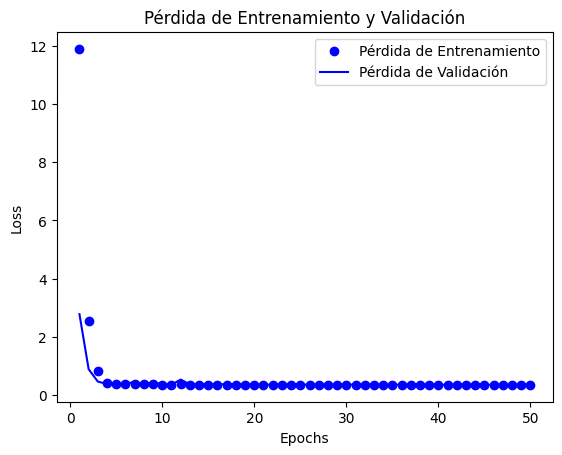

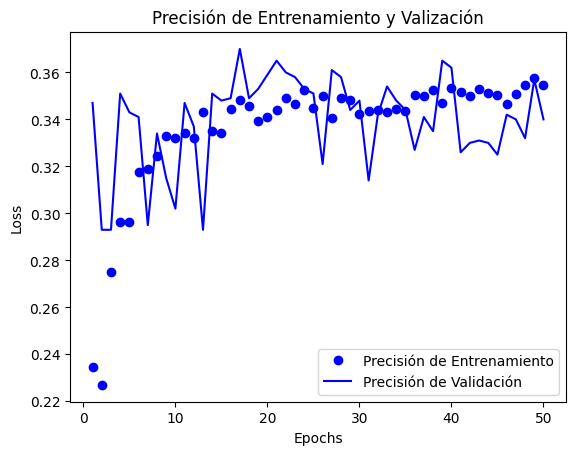

In [18]:
# Separar conjuntos de entrenamiento y validación
validation_size = 1000
train_images_val = train_images[:validation_size]
partial_train_images_train = train_images[validation_size:]

train_label_val = train_labels[:validation_size]
partial_train_label_train = train_labels[validation_size:]

history = model.fit(
    partial_train_images_train,
    partial_train_label_train,
    epochs=50,
    batch_size=32,
    validation_data=(train_images_val, train_label_val)
)

history_dict = history.history
history_dict.keys()
print(history_dict['loss'])
print(history_dict['accuracy'])
print(history_dict['val_loss'])
print(history_dict['val_accuracy'])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" es para "punto azul"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # Limpia la figura
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Valización')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



Ahora a partir del gráfico se puede observar el número de épocas óptimo, volvemos a compilar y ejecutar el modelo usando todos los datos de entrenamiento, pero ahora eligiendo 17 épocas.

In [20]:
# Compilación del modelo
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


# Entrenamiento del modelo
history = model.fit(
    train_images,
    train_labels,
    epochs=17,
    batch_size=32,
)

# Evaluación del modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Precisión en el conjunto de prueba: {test_accuracy}')

Epoch 1/17
175/175 [==============================] - 11s 48ms/step - loss: 0.3569 - accuracy: 0.3480
Epoch 2/17
175/175 [==============================] - 8s 47ms/step - loss: 0.3568 - accuracy: 0.3439
Epoch 3/17
175/175 [==============================] - 8s 46ms/step - loss: 0.3560 - accuracy: 0.3566
Epoch 4/17
175/175 [==============================] - 8s 47ms/step - loss: 0.3572 - accuracy: 0.3450
Epoch 5/17
175/175 [==============================] - 8s 47ms/step - loss: 0.3562 - accuracy: 0.3534
Epoch 6/17
175/175 [==============================] - 8s 46ms/step - loss: 0.3552 - accuracy: 0.3555
Epoch 7/17
175/175 [==============================] - 8s 47ms/step - loss: 0.3554 - accuracy: 0.3427
Epoch 8/17
175/175 [==============================] - 8s 47ms/step - loss: 0.3563 - accuracy: 0.3359
Epoch 9/17
175/175 [==============================] - 8s 46ms/step - loss: 0.3569 - accuracy: 0.3543
Epoch 10/17
175/175 [==============================] - 8s 47ms/step - loss: 0.3553 - accur

# **Hallazgos:**


Ahora haremos predicicciones utilizando los modelos de redes neuronales previamente entrenados. Una predicción es una suposición sobre el resultado final.

Primero tomamos imagenes de prueba y el modelo procesa la imagen a través de sus capas y realiza cálculos para obtener las predicciones. Esta predicción es un array de las probabilidades de que la imagen test pertenezca a cada una de las clases que tenemos. Es decir, cada valor nos muestra la probabilidad de que la imagen pertenezca a cada una de las enfermedades.


44/44 [==============================] - 1s 12ms/step


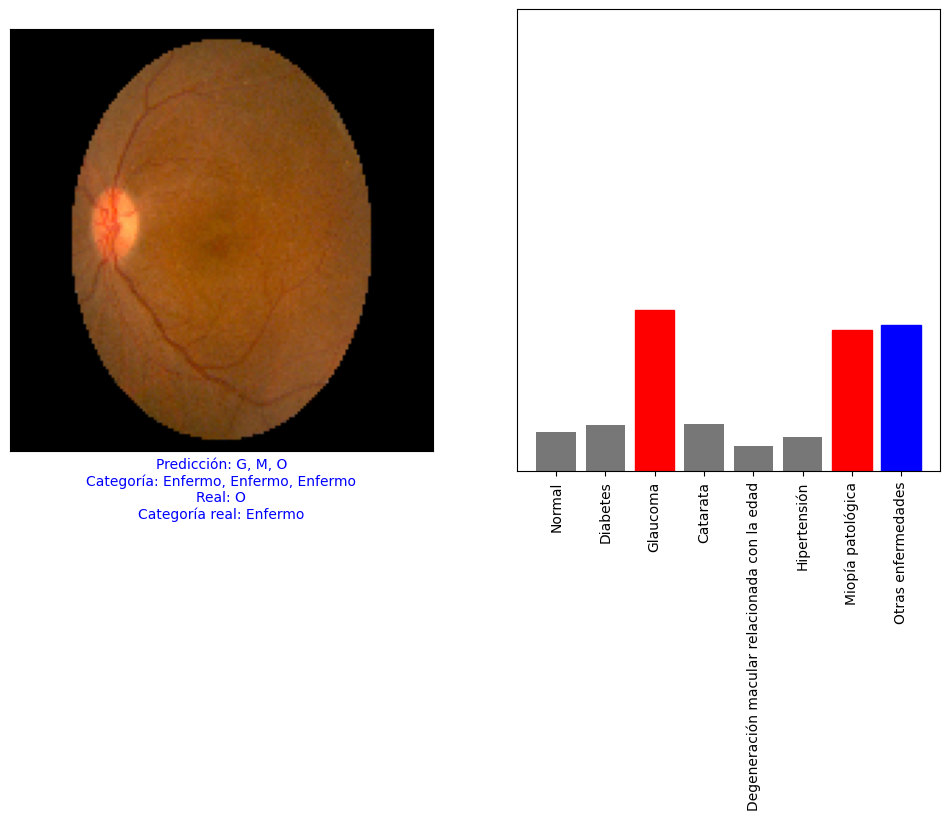

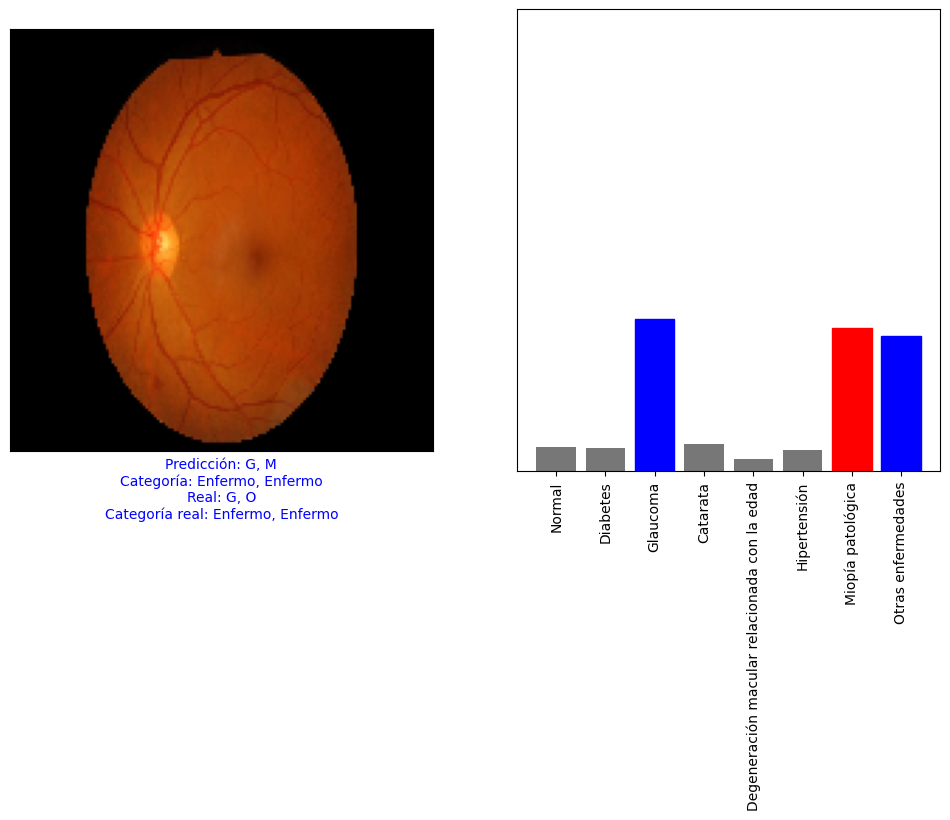

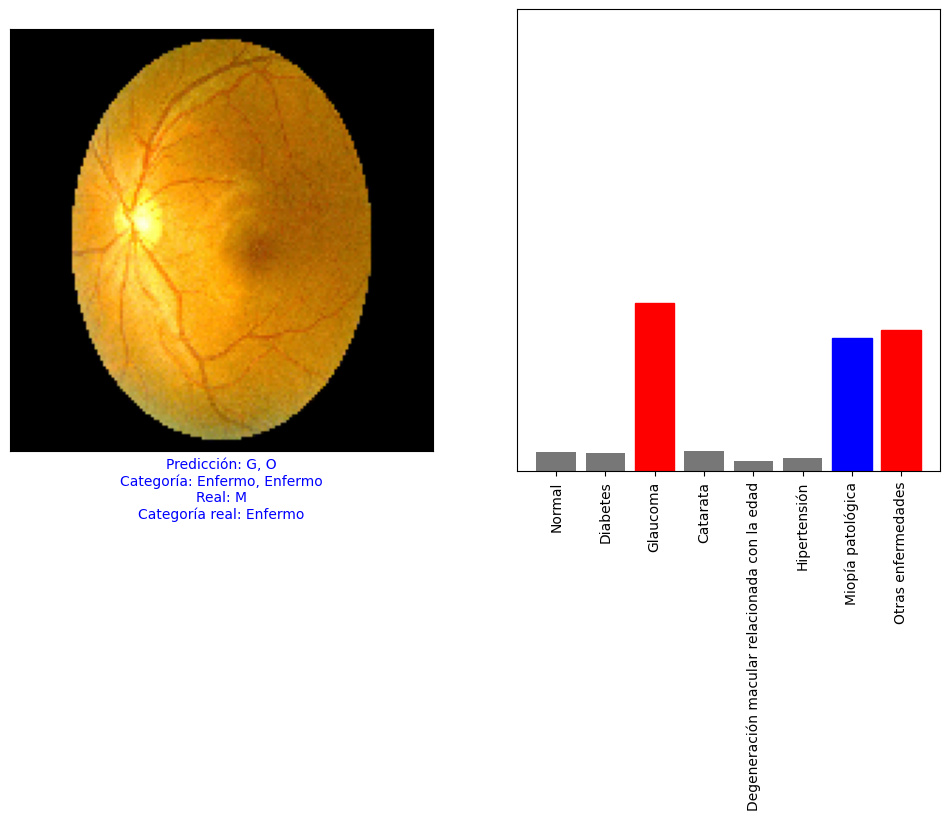

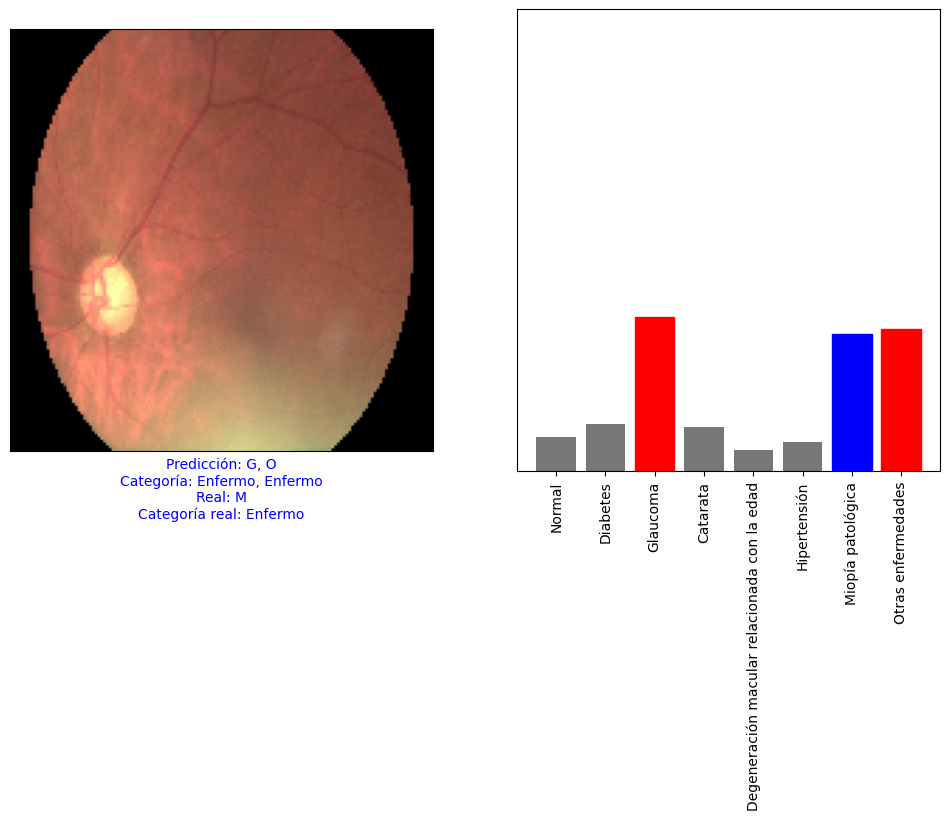

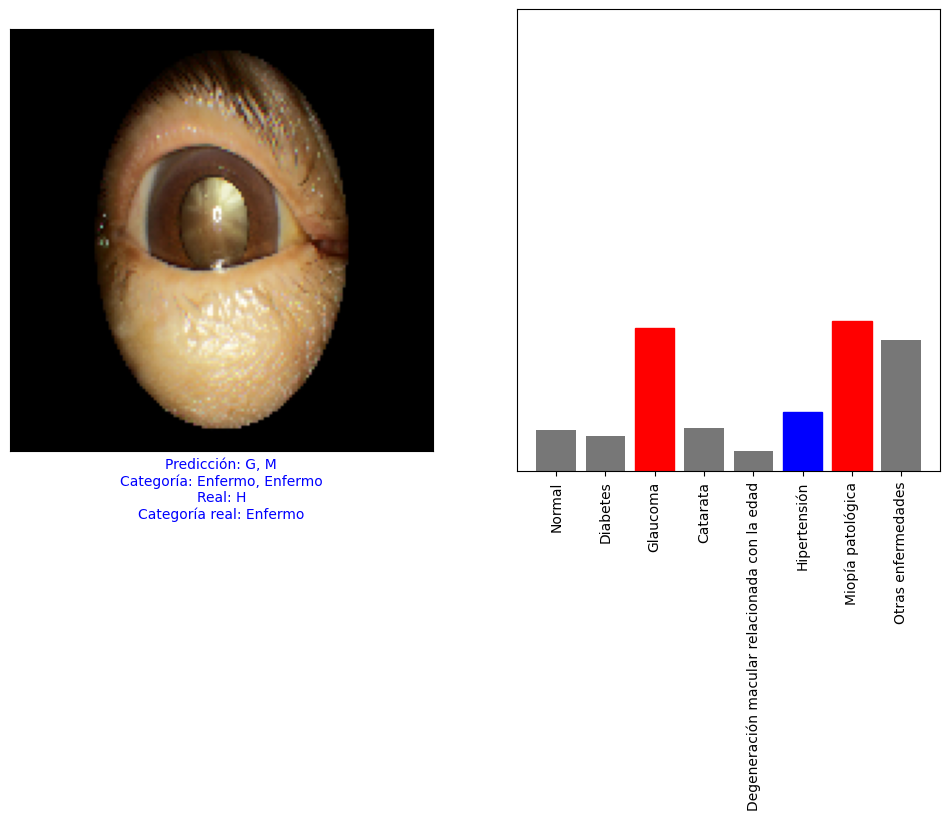

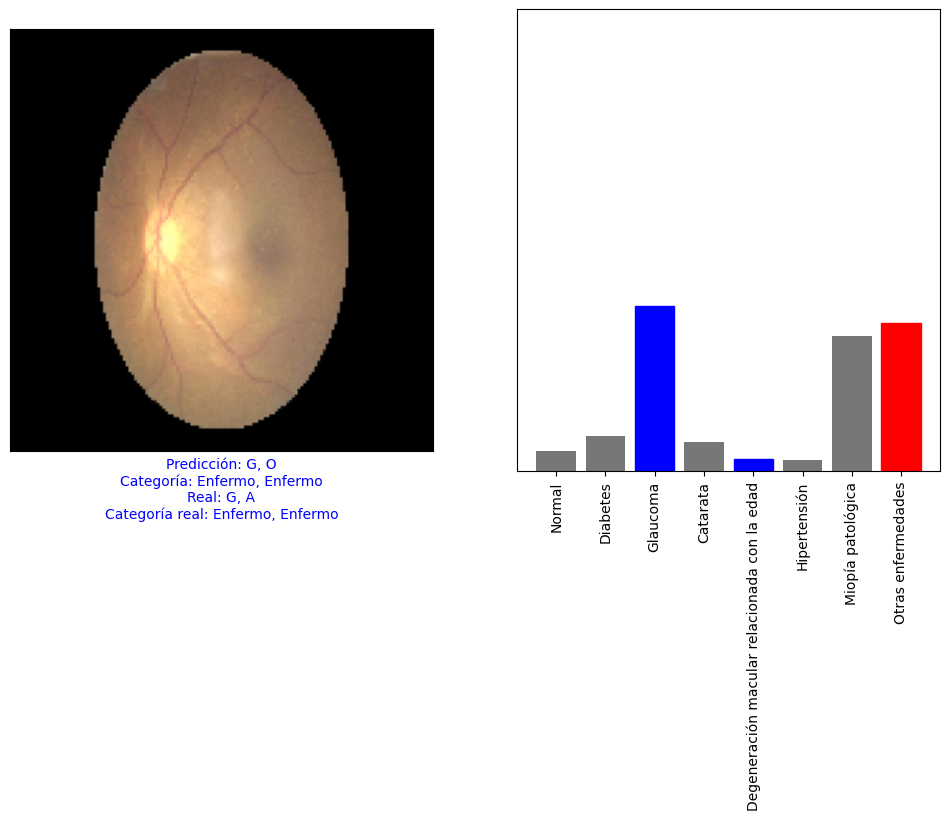

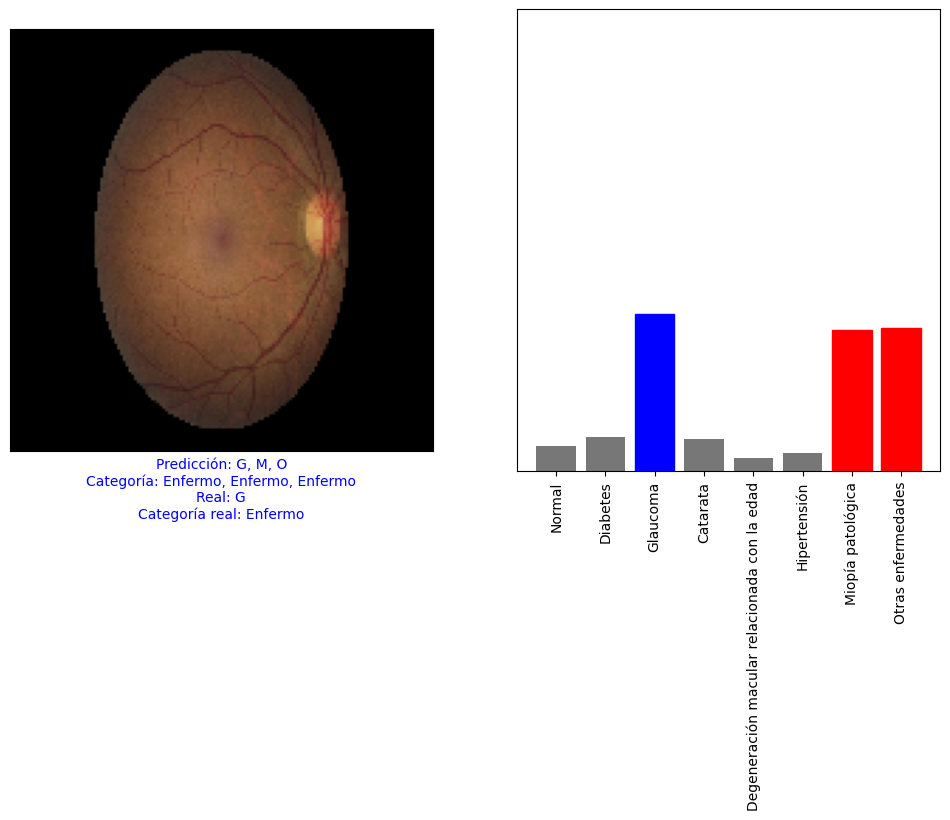

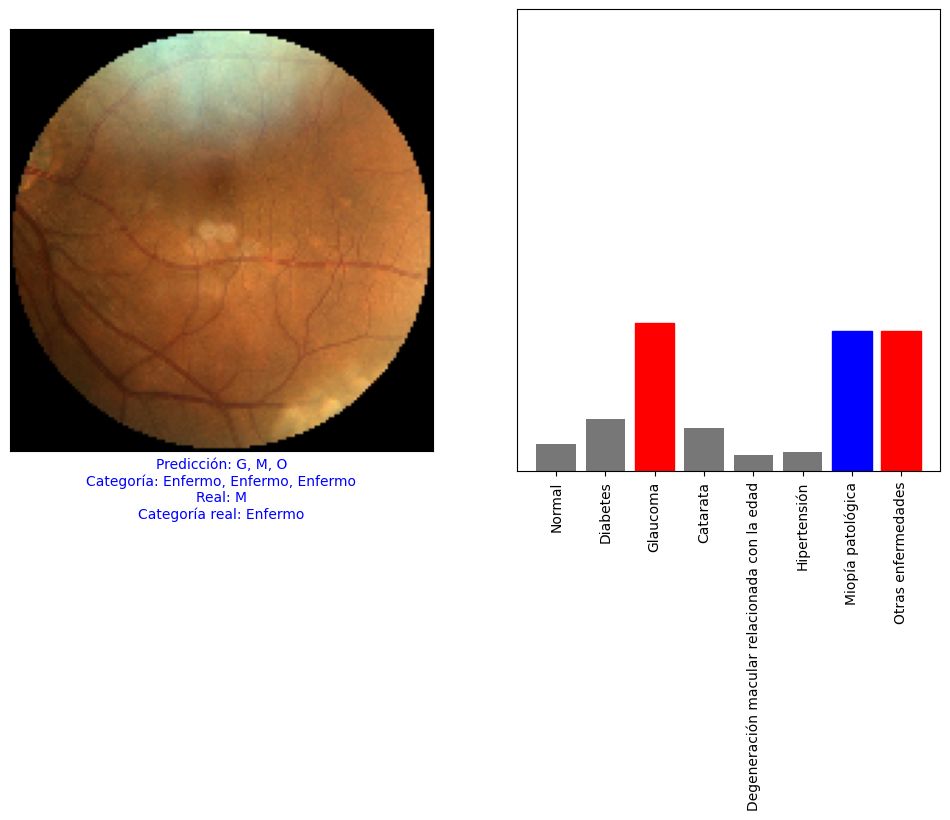

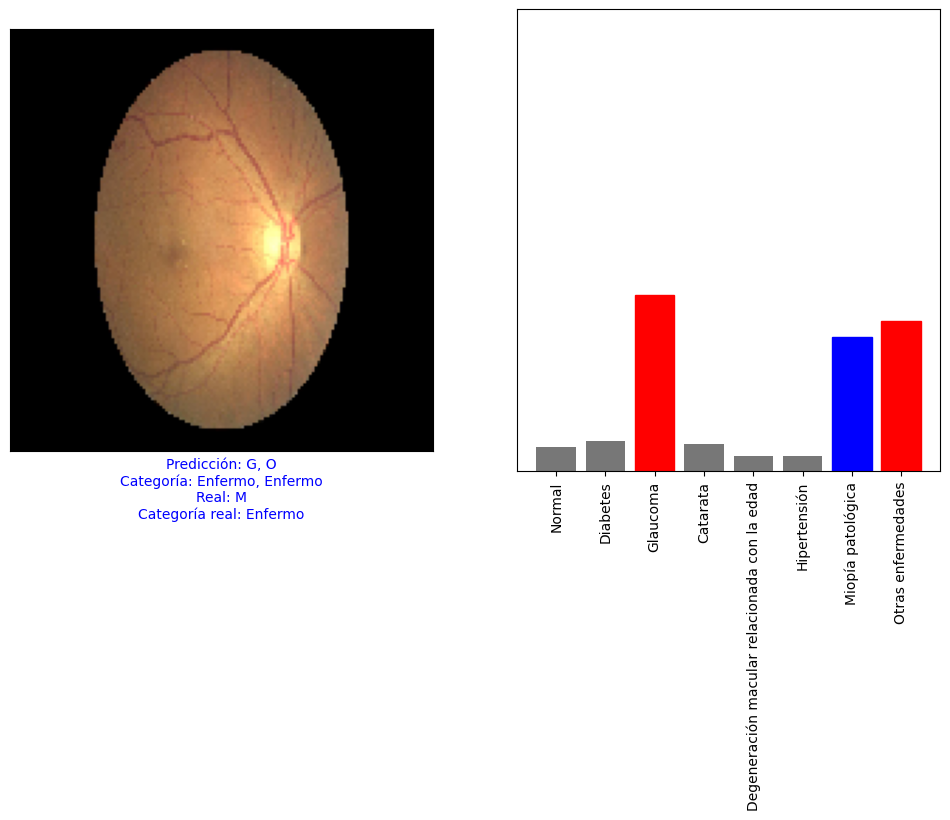

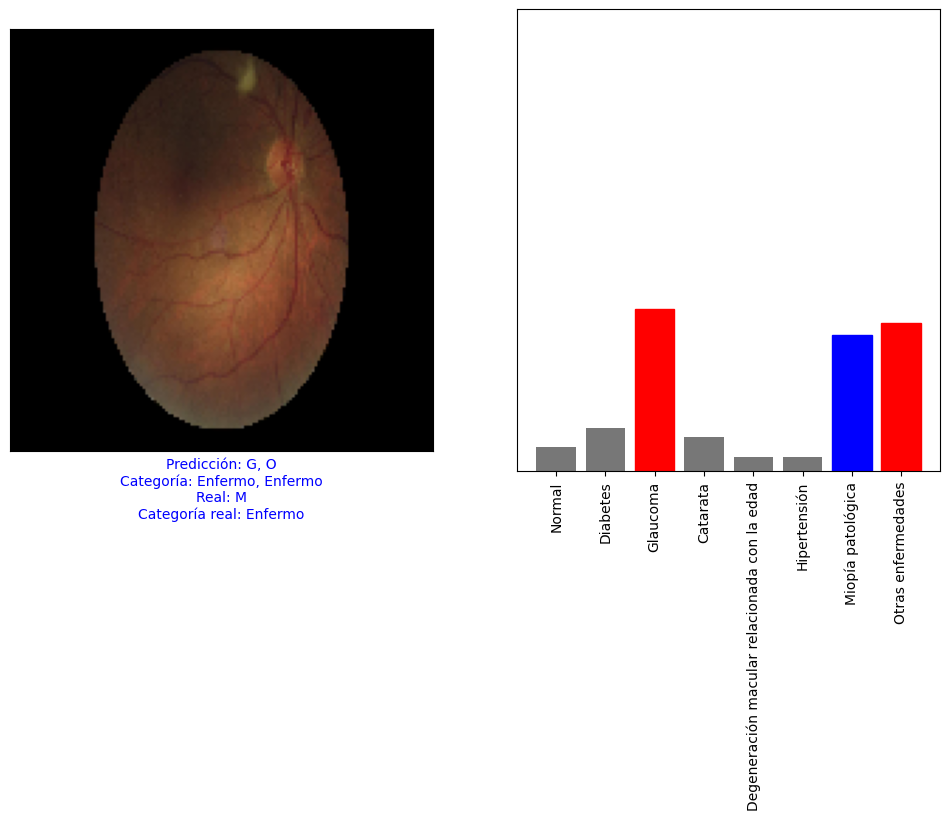

In [22]:
diccionario_ojos = {
    'Sano': ['Normal'],
    'Enfermo': ['Diabetes', 'Glaucoma', 'Catarata', 'Degeneración macular relacionada con la edad', 'Hipertensión', 'Miopía patológica', 'Otras enfermedades']
}

label_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
labelcolumns = ['Normal','Diabetes', 'Glaucoma', 'Catarata', 'Degeneración macular relacionada con la edad', 'Hipertensión', 'Miopía patológica', 'Otras enfermedades']

num_classes = len(label_columns)

predictions = model.predict(test_images)

# Umbral para considerar una etiqueta como positiva ya que se obtuvo una precisión cercana al 30%
threshold = 0.3

test_filenames = [filename for filename in os.listdir(train_dir) if filename.endswith('.jpg')]


# Iterar sobre varias imágenes para mostrar las predicciones
for j in range(10):
    pred = predictions[j]
    predicted_labels = [label_columns[i] for i, p in enumerate(pred) if p > threshold]

def encontrar_vector(palabra):
    if palabra == 'N':
      palabra = 'Normal'
    elif palabra == 'D':
      palabra = 'Diabetes'
    elif palabra == 'G':
      palabra = 'Glaucoma'
    elif palabra == 'C':
      palabra = 'Catarata'
    elif palabra == 'A':
      palabra = 'Degeneración macular relacionada con la edad'
    elif palabra == 'H':
      palabra = 'Hipertensión'
    elif palabra == 'M':
      palabra = 'Miopía patológica'
    elif palabra == 'O':
      palabra = 'Otras enfermedades'
    for clave, valor in diccionario_ojos.items():
        if palabra in valor:
            return clave
    return 'Desconocido'
import matplotlib.pyplot as plt
import numpy as np

def plot_image(m, predictions_array, true_label, img, threshold=0.3):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_labels = [label_columns[i] for i in range(len(predictions_array)) if predictions_array[i] > threshold]
    true_labels = [label_columns[i] for i in range(len(true_label)) if true_label[i] == 1]

    predicted_categories = [encontrar_vector(label) for label in predicted_labels]
    true_categories = [encontrar_vector(label) for label in true_labels]

    if set(predicted_categories) == set(true_categories):
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"Predicción: {', '.join(predicted_labels)}\n"
               f"Categoría: {', '.join(predicted_categories)}\n"
               f"Real: {', '.join(true_labels)}\n"
               f"Categoría real: {', '.join(true_categories)}",
               color=color)

def plot_value_array(m, prediction_array, true_label):
    plt.grid(False)
    plt.xticks(range(num_classes), labelcolumns, rotation='vertical')
    plt.yticks([])
    thisplot = plt.bar(range(num_classes), prediction_array, color="#777777")
    plt.ylim([0, 1])

    for i in range(num_classes):
        if prediction_array[i] > threshold:
            thisplot[i].set_color('red')
        if true_label[i] == 1:
            thisplot[i].set_color('blue')

for h in range(10):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plot_image(h, predictions[h], test_labels[h], test_images[h])
    plt.subplot(1, 2, 2)
    plot_value_array(h, predictions[h], test_labels[h])
    plt.show()


En nuestro análisis, nos centramos en qué tan precisa es la clasificación del modelo, ya que esto es importante para diagnosticar enfermedades oculares correctamente. Esta precisión es clave, especialmente si pensamos en usar este modelo en la práctica oftalmológica. Los doctores podrían confiar en él para identificar la enfermedad correcta y, de esta manera, recomendar el tratamiento más adecuado para cada paciente. En pocas palabras, no se trata solo de que el modelo funcione bien, sino de asegurarnos de que ayude a los médicos a tomar las mejores decisiones para sus pacientes.

En la revisión de nuestros hallazgos del proyecto, encontramos que, aunque 'normal' y 'otras enfermedades' eran las clases más representadas en nuestros datos, el modelo solía predecir mayormente miopía o glaucoma. Esto nos tomó por sorpresa y resalta un punto interesante sobre cómo los sistemas de aprendizaje automático identifican enfermedades oculares. Sin ser expertos en oftalmología, no podemos decir con certeza por qué el modelo confunde otras enfermedades con miopía o glaucoma. Podría ser que estas últimas no tengan características muy distintivas que las diferencien claramente de otras condiciones.

Aunque la precisión del modelo estuvo acorde con lo que esperábamos, ya que sabíamos que la precisión no iba a ser alta porque los datos no estaban equitativamente representados al iniciar el entrenamiento, la forma en que distribuyó sus predicciones nos recuerda lo crucial que es entender bien nuestros datos y qué está captando realmente el modelo. Esto resalta la importancia de tener un conjunto de entrenamiento bien equilibrado, donde todas las categorías estén representadas de manera justa.

Basándonos en investigaciones como la del estudio "Deep Learning for Ocular Disease Recognition: An Inner-Class Balance", entendemos que identificar enfermedades oculares a partir de imágenes del fondo del ojo puede ser bastante complejo y propenso a errores si se hace a mano. Por suerte, modelos de aprendizaje profundo, como el VGG-19, han demostrado ser bastante buenos para mejorar la clasificación de estas imágenes. Incluso en datos no tan equilibrados, han funcionado bien al simplificar la clasificación de múltiples enfermedades a un formato binario. Por ejemplo, el VGG-19 fue especialmente preciso al distinguir entre miopía patológica y cataratas frente a imágenes normales del ojo.

# **Trabajos Futuros:**

Como parte de la estrategia a largo plazo para el perfeccionamiento y mejorar nuestro modelo de clasificación de imágenes de fondo de ojo, hemos planteado varias iniciativas para el desarrollo de herramientas de diagnóstico asistido por inteligencia artificial.

Principalmente, reconocemos la importancia de contar con un conjunto de datos bien balanceado. Por ello, se priorizará la ampliación de nuestra base de datos con un mayor número de imágenes pertenecientes a las clases menos representadas. Esto no solo mejorará la generalización de nuestro modelo, sino que también atenderá la necesidad de reducir el sesgo a las desigualdades en la representación de datos. De este modo queremos garantizar que nuestro modelo refleje con precisión la diversidad y la variabilidad de las condiciones oculares que se presentan en la práctica clínica.

Además, también nos gustaría implementar un enfoque de entrenamiento multietapa. Este enfoque se fundamenta en la idea de un proceso de aprendizaje jerárquico y gradual, donde el modelo primero adquiere la capacidad de discernir entre categorías generales, como determinar si una condición patológica está presente o no (es decir, si un ojo esta enfermo o no).  Confiamos en que este enfoque escalonado no solo mejorará la capacidad discriminativa del modelo, sino que también facilitará la interpretación de sus predicciones.

Por otro lado, la técnica de oversampling ha captado nuestro interés debido a su potencial para abordar el desequilibrio de clases. Aunque no hemos sido capaces de aplicar esta técnica, nos gustaría probarla en futuras iteraciones  del modelo.

Las iniciativas mencionadas forman parte de un esfuerzo más amplio para no solo perfeccionar las métricas operativas de nuestro modelo, como la precisión y el recall, sino también para garantizar la practicidad y la fiabilidad de nuestras soluciones.
Este modelo podría integrarse en un futuro en el flujo de trabajo de oftalmólogos y optometristas para preseleccionar casos, identificar condiciones que requieren atención inmediata o rastrear cambios en la salud ocular de los pacientes a lo largo del tiempo.
